In [1]:
using Distributed
addprocs(44);

In [2]:
using pulse_input_DDM

In [3]:
path = "/usr/people/briandd/Projects/neural_DDM_analysis/data/hanks_data_sessions"

"/usr/people/briandd/Projects/neural_DDM_analysis/data/hanks_data_sessions"

In [4]:
#ratnames = ["B068","T034","T036","T063","T030"] #FOF
#ratnames = ["T035","T011","B053"] PPC
#ratnames = ["T080","T103","E021"] #STR

In [5]:
region, rat = "FOF", "T063"

("FOF", "T063")

In [6]:
sessions = filter(x->occursin(rat,x), readdir(path))

17-element Array{String,1}:
 "T063_191956.mat"
 "T063_193936.mat"
 "T063_194554.mat"
 "T063_194649.mat"
 "T063_194770.mat"
 "T063_194898.mat"
 "T063_195271.mat"
 "T063_195546.mat"
 "T063_195676.mat"
 "T063_195791.mat"
 "T063_196336.mat"
 "T063_196580.mat"
 "T063_196708.mat"
 "T063_197075.mat"
 "T063_197212.mat"
 "T063_197479.mat"
 "T063_198004.mat"

In [7]:
output = load.(joinpath.(path, sessions), true, delay=0.0);

In [8]:
data = getindex.(output, 1)
μ_rnt = getindex.(output, 2);
μ_t = getindex.(output, 3);

In [14]:
data = vcat(data...)
μ_rnt = vcat(μ_rnt...)
μ_t = vcat(μ_t...);

In [15]:
f, ncells, ntrials, nparams = "Sigmoid", map(x-> x[1].ncells, data), length.(data), 4

("Sigmoid", [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [199, 188, 190, 190, 183, 249, 195, 161, 161, 259  …  264, 249, 249, 249, 300, 300, 319, 309, 309, 309], 4)

In [16]:
nconds, dt, n = 2, 1e-2, 53

(2, 0.01, 53)

In [17]:
output = pulse_input_DDM.process_spike_data.(μ_rnt, data, ncells; nconds=nconds);

μ_ct = getindex.(output, 1)
σ_ct = getindex.(output, 2);

In [18]:
using PyPlot

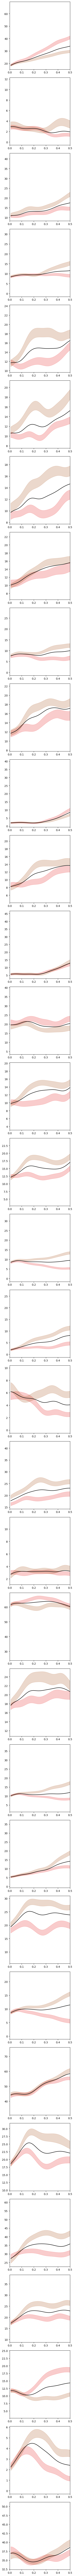

In [19]:
num_rows, num_cols = length(data), maximum(map(x-> x[1].ncells, data))
fig, ax = subplots(num_rows, num_cols, figsize=(4*maximum(map(x-> x[1].ncells, data)), 4*length(data)))
my_colors = ["#E50000","#9F3F00","#5A7F00","#15BF00"]
#PPC colors = ["#1822A0","#5D4A7A","#A37354","#E99C2F"]
#STR colors = ["#A01892","#B85C71","#D0A150","#E9E62F"]

for i in 1:num_rows      
    for j in 1:data[i][1].ncells   
        
        if (num_rows == 1) && (data[i][1].ncells == 1)
        
            for k = 1:nconds   

                ax.fill_between((1:length(μ_ct[i][j][k]))*dt,
                    μ_ct[i][j][k] + σ_ct[i][j][k],
                    μ_ct[i][j][k] - σ_ct[i][j][k],
                    alpha=0.2, color=my_colors[k])                                   

                ax.set_xlim((0, 0.5))

            end   

            ax.plot((1:length(μ_t[i][j]))*dt,
                μ_t[i][j], color="black")
            
            
        elseif (num_rows == 1) && (data[i][1].ncells > 1)
            
            for k = 1:nconds   

                ax[j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                    μ_ct[i][j][k] + σ_ct[i][j][k],
                    μ_ct[i][j][k] - σ_ct[i][j][k],
                    alpha=0.2, color=my_colors[k])                                  

                ax[j].set_xlim((0, 0.5))

            end   

            ax[j].plot((1:length(μ_t[i][j]))*dt,
                μ_t[i][j], color="black")
            
        elseif num_rows > 1
             
            for k = 1:nconds   

                ax[i,j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                    μ_ct[i][j][k] + σ_ct[i][j][k],
                    μ_ct[i][j][k] - σ_ct[i][j][k],
                    alpha=0.2, color=my_colors[k])                                   

                ax[i,j].set_xlim((0, 0.5))

            end   

            ax[i,j].plot((1:length(μ_t[i][j]))*dt,
                μ_t[i][j], color="black")
            
        end

    end
    
end

tight_layout() 

## Fit

In [20]:
θy0 = vcat(vcat(initialize_θy.(data, f)...)...);

In [21]:
options0 = neuraloptions(ncells=ncells,
    fit=vcat(falses(dimz), trues(sum(ncells)*nparams)),
    x0=vcat([0., 30., 0. + eps(), 0., 0., 1. - eps(), 0.008], θy0))

neuraloptions
  ncells: Array{Int64}((34,)) [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  nparams: Int64 4
  f: String "Sigmoid"
  fit: Array{Bool}((143,)) Bool[0, 0, 0, 0, 0, 0, 0, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  lb: Array{Float64}((143,)) [0.0, 8.0, -5.0, 0.0, 0.0, 0.01, 0.005, -100.0, 0.0, -10.0  …  -10.0, -10.0, -100.0, 0.0, -10.0, -10.0, -100.0, 0.0, -10.0, -10.0]
  ub: Array{Float64}((143,)) [30.0, 32.0, 5.0, 200.0, 5.0, 1.2, 1.0, 100.0, 100.0, 10.0  …  10.0, 10.0, 100.0, 100.0, 10.0, 10.0, 100.0, 100.0, 10.0, 10.0]
  x0: Array{Float64}((143,)) [0.0, 30.0, 2.220446049250313e-16, 0.0, 0.0, 0.9999999999999998, 0.008, 25.436757512229207, 44.93361285814116, -0.00244743378860693  …  -0.002245340779347089, 0.0, 0.1, 3.9404951169657054, 0.0005687069143647916, 0.0, 36.29113575946466, 9.71525401689317, 0.001225733958446602, 0.0]


In [22]:
model, = optimize(data, options0; show_trace=false)

optimization complete. converged: true 



(neuralDDM{θneural{θz{Float64},Array{Array{Sigmoid{Float64},1},1}},Array{Any,1}}
  θ: θneural{θz{Float64},Array{Array{Sigmoid{Float64},1},1}}
  data: Array{Any}((34,))
,  * Status: success

 * Candidate solution
    Minimizer: [-3.73e-01, 4.47e+01, -2.29e-03,  ...]
    Minimum:   3.195141e+05

 * Found with
    Algorithm:     Fminbox with BFGS
    Initial Point: [2.54e+01, 4.49e+01, -2.45e-03,  ...]

 * Convergence measures
    |x - x'|               = 1.01e-01 ≰ 1.0e-10
    |x - x'|/|x'|          = 1.07e-03 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.63e-01 ≰ 1.0e-06
    |f(x) - f(x')|/|f(x')| = 8.22e-07 ≰ 0.0e+00
    |g(x)|                 = 1.16e+00 ≰ 1.0e-03

 * Work counters
    Seconds run:   626  (vs limit Inf)
    Iterations:    2
    f(x) calls:    240
    ∇f(x) calls:   55
)

In [23]:
model.θ.θy

34-element Array{Array{Sigmoid{Float64},1},1}:
 [Sigmoid{Float64}
  a: Float64 -0.3725658747115265
  b: Float64 44.691939558366336
  c: Float64 -0.002292912634088162
  d: Float64 -4.520715589657881
]   
 [Sigmoid{Float64}
  a: Float64 -2.28138766983561
  b: Float64 2.123654702109463
  c: Float64 0.0005033369423754263
  d: Float64 8.24090451616394
]        
 [Sigmoid{Float64}
  a: Float64 -0.5137864158928174
  b: Float64 13.232079959233854
  c: Float64 0.002200260402688703
  d: Float64 -3.1844277518944257
]   
 [Sigmoid{Float64}
  a: Float64 -0.3429734018135308
  b: Float64 21.18516731065837
  c: Float64 0.0027835573008954777
  d: Float64 -4.1681951889294515
]   
 [Sigmoid{Float64}
  a: Float64 -0.6495374521415688
  b: Float64 6.258977986315432
  c: Float64 0.0010451935586205776
  d: Float64 -2.1127047329501356
]   
 [Sigmoid{Float64}
  a: Float64 -1.8514195133955582
  b: Float64 9.360450661752017
  c: Float64 0.0013236352469120378
  d: Float64 -1.4136180955872657
]   
 [Sigmoid{Float64

In [25]:
fit=vcat(falses(1), trues(dimz-1), trues(sum(ncells)*nparams))
#x0=vcat([0.1, 12., -2., 10., 0.1, 0.8, 0.008], θy0);
x0=vcat([0.1, 12., -2., 10., 0.1, 0.8, 0.008], pulse_input_DDM.flatten(model.θ)[dimz+1:end]);

In [26]:
options = neuraloptions(ncells=ncells, x0=x0, fit=fit, nparams=nparams, f=f);

In [ ]:
model, = optimize(data, options, n);

Fminbox
-------
Initial mu = 0.0146626

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.0146626

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     3.194914e+05     1.162316e+03
 * time: 6.389617919921875e-5
     1     3.193386e+05     8.713090e+02
 * time: 141.46873307228088
     2     3.193373e+05     8.694150e+02
 * time: 283.83394503593445
     3     3.193291e+05     1.620396e+04
 * time: 423.37175607681274
     4     3.191091e+05     9.734260e+02
 * time: 563.4353668689728
     5     3.190141e+05     9.504972e+02
 * time: 703.5441439151764
     6     3.189884e+05     9.557628e+02
 * time: 842.5922999382019
     7     3.189831e+05     9.506510e+02
 * time: 983.4637279510498
     8     3.189786e+05     9.503783e+02
 * time: 1122.2577788829803
     9     3.189772e+05     9.498943e+02
 * time: 1263.8856909275055
    10     3.189747e+05     9.488353e+02
 * time: 1402.6700909137726
    11     3.189727e+05     9.46

   117     3.166949e+05     3.383242e+02
 * time: 19538.21658706665
   118     3.166838e+05     3.766786e+02
 * time: 19727.17284989357
   119     3.166772e+05     5.720463e+02
 * time: 19915.59975004196
   120     3.166711e+05     7.048148e+02
 * time: 20104.46153306961
   121     3.166640e+05     8.122947e+02
 * time: 20356.180885076523
   122     3.166545e+05     8.194195e+02
 * time: 20545.894762039185
   123     3.166490e+05     7.658875e+02
 * time: 20736.26497888565
   124     3.166407e+05     7.256235e+02
 * time: 20925.594959020615
   125     3.166327e+05     6.121181e+02
 * time: 21116.35973596573
   126     3.166244e+05     5.427733e+02
 * time: 21306.47390604019
   127     3.166128e+05     5.208836e+02
 * time: 21496.117594003677
   128     3.166005e+05     3.894914e+02
 * time: 21688.47957587242
   129     3.165887e+05     3.507534e+02
 * time: 21881.238723039627
   130     3.165811e+05     3.681432e+02
 * time: 22073.048402071
   131     3.165726e+05     3.872252e+02
 * t

In [ ]:
model.θ.θz

In [ ]:
model.θ.θy

## Model fit

In [105]:
LL_ML = loglikelihood(model.θ, data, n)

-315819.66301328747

In [106]:
LL_null = mapreduce((data,θy)-> mapreduce(data-> mapreduce(n->
    pulse_input_DDM.neural_null(data.spikes[n], θy[n]([0.], data.input_data.λ0[n]), dt),
        +, 1:data.ncells), +, data), +, data, model.θ.θy)

-319759.9091203376

In [107]:
LL_ML - LL_null

3940.2461070501013

## Sample rates

In [206]:
μ_λ, μ_c_λ = pulse_input_DDM.synthetic_λ(model.θ, data; num_samples=100, nconds=nconds);

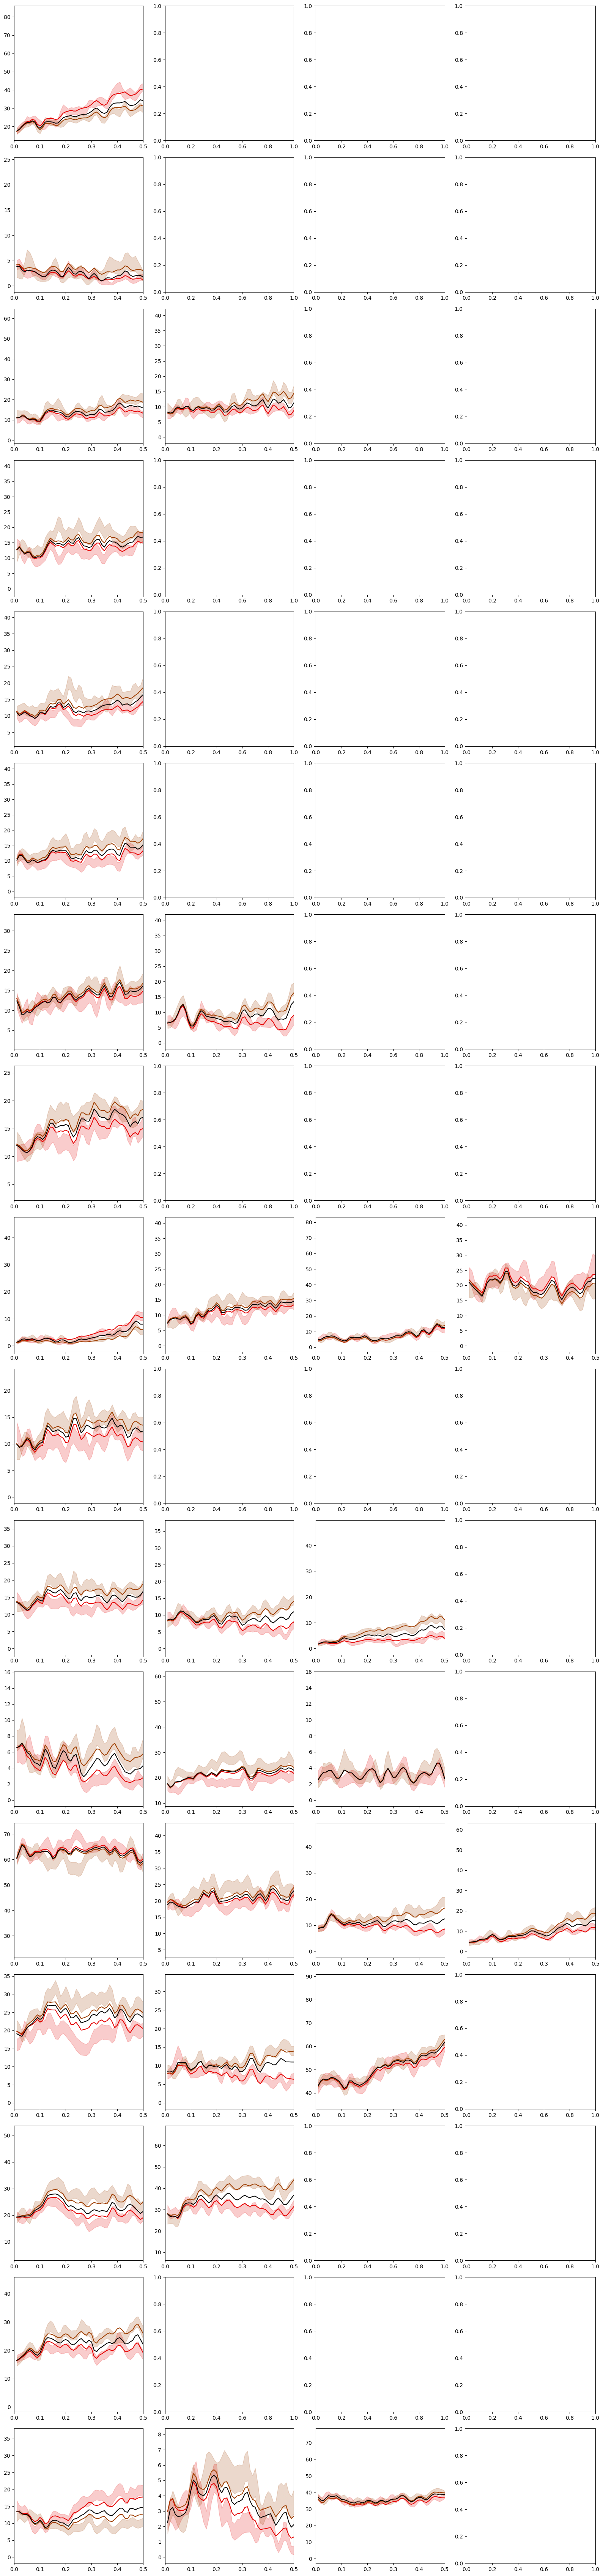

In [207]:
num_rows, num_cols = length(data), maximum(map(x-> x[1].ncells, data))
fig, ax = subplots(num_rows, num_cols, figsize=(4*maximum(map(x-> x[1].ncells, data)), 4*length(data)))
my_colors = ["#E50000","#9F3F00","#5A7F00","#15BF00"]
#PPC colors = ["#1822A0","#5D4A7A","#A37354","#E99C2F"]
#STR colors = ["#A01892","#B85C71","#D0A150","#E9E62F"]

for i in 1:num_rows      
    for j in 1:data[i][1].ncells   
        
        if (num_rows == 1) && (data[i][1].ncells == 1)
        
            for k = 1:nconds   

                ax.fill_between((1:length(μ_ct[i][j][k]))*dt,
                    μ_ct[i][j][k] + σ_ct[i][j][k],
                    μ_ct[i][j][k] - σ_ct[i][j][k],
                    alpha=0.2, color=my_colors[k]) 
                
                ax.plot((1:length(μ_c_λ[i][j][k]))*dt,
                    μ_c_λ[i][j][k], color=my_colors[k])  

                ax.set_xlim((0, 0.5))

            end   

            ax.plot((1:length(μ_t[i][j]))*dt,
                μ_t[i][j], color="black")
            
            
        elseif (num_rows == 1) && (data[i][1].ncells > 1)
            
            for k = 1:nconds   

                ax[j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                    μ_ct[i][j][k] + σ_ct[i][j][k],
                    μ_ct[i][j][k] - σ_ct[i][j][k],
                    alpha=0.2, color=my_colors[k])  
                
                ax[j].plot((1:length(μ_c_λ[i][j][k]))*dt,
                    μ_c_λ[i][j][k], color=my_colors[k])  

                ax[j].set_xlim((0, 0.5))

            end   

            ax[j].plot((1:length(μ_t[i][j]))*dt,
                μ_t[i][j], color="black")
            
        elseif num_rows > 1
             
            for k = 1:nconds   

                ax[i,j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                    μ_ct[i][j][k] + σ_ct[i][j][k],
                    μ_ct[i][j][k] - σ_ct[i][j][k],
                    alpha=0.2, color=my_colors[k]) 
                
                ax[i,j].plot((1:length(μ_c_λ[i][j][k]))*dt,
                    μ_c_λ[i][j][k], color=my_colors[k])  

                ax[i,j].set_xlim((0, 0.5))

            end   

            ax[i,j].plot((1:length(μ_t[i][j]))*dt,
                μ_t[i][j], color="black")
            
        end

    end
    
end

tight_layout() 

In [108]:
SSx(x, nT) = sum(sum.(map(x-> x[1:nT].^2, vcat(vcat((x)...)...)))) 

SSx (generic function with 1 method)

In [ ]:
SSx(x, nT) = sum(sum.(map(x-> x[1:nT].^2, vcat(vcat((x)...)...)))) 

In [137]:
using Statistics: mean

In [208]:
blah = μ_λ - μ_rnt;

In [209]:
blah2 = [[sum([sum((blah[s][r][n][1:40]).^2) for r in 1:length(blah[s])]) 
        for n in 1:length(blah[s][1])] for s in 1:length(blah)];

In [210]:
blah3 = [[sum([sum((μ_rnt[s][r][n][1:40]).^2) for r in 1:length(μ_rnt[s])]) 
        for n in 1:length(μ_rnt[s][1])] for s in 1:length(μ_rnt)];

In [211]:
blah4 = [[1 - (blah2[s][n]/blah3[s][n]) for n in 1:length(blah2[s])] for s in 1:length(blah2)]

17-element Array{Array{Float64,1},1}:
 [0.6653905034637965]                                                              
 [0.077310343806819]                                                               
 [0.4084470582383626, 0.33962986290265296]                                         
 [0.42804802290764676]                                                             
 [0.37786798424011003]                                                             
 [0.37899237035976985]                                                             
 [0.4190968878204395, 0.30326411408045595]                                         
 [0.44879962614467417]                                                             
 [0.08246283149487477, 0.3652412164956518, 0.20050370370855075, 0.4228347651921949]
 [0.4008746174982032]                                                              
 [0.46673932145052555, 0.3226400114893764, 0.16400400687340333]                    
 [0.1676552246924663, 0.57812013143836

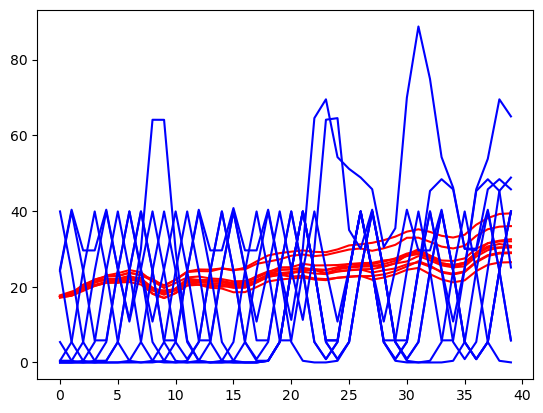

10-element Array{Array{PyCall.PyObject,1},1}:
 [PyObject <matplotlib.lines.Line2D object at 0x7f652f0b0cf8>]
 [PyObject <matplotlib.lines.Line2D object at 0x7f652f0be0f0>]
 [PyObject <matplotlib.lines.Line2D object at 0x7f652f0be4a8>]
 [PyObject <matplotlib.lines.Line2D object at 0x7f652f0be860>]
 [PyObject <matplotlib.lines.Line2D object at 0x7f652f0bec18>]
 [PyObject <matplotlib.lines.Line2D object at 0x7f64ef57b208>]
 [PyObject <matplotlib.lines.Line2D object at 0x7f64ef57b3c8>]
 [PyObject <matplotlib.lines.Line2D object at 0x7f64ef57b780>]
 [PyObject <matplotlib.lines.Line2D object at 0x7f64ef57bb38>]
 [PyObject <matplotlib.lines.Line2D object at 0x7f64ef571128>]

In [213]:
plot.([μ_λ[1][r][1][1:40] for r in 1:10], color="red")
plot.([μ_rnt[1][r][1][1:40] for r in 1:10], color="blue")

In [129]:
1 - SSx(μ_λ - μ_rnt, 40)/SSx(μ_rnt, 40)

0.85258056631619

In [109]:
1 - SSx(μ_c_λ - μ_ct, 40)/SSx(μ_ct, 40)

0.9970826704894704

### Compute Hessian
Blah blah blah

In [110]:
H = Hessian(model, n)
CI, HPSD = CIs(H);

┌ Warning: Hessian is not positive definite. Approximated by closest PSD matrix.
│             ||ϵ||/||H|| is 2.0000294512081
└ @ pulse_input_DDM /usr/people/briandd/Projects/pulse_input_DDM/src/base_model.jl:19


In [111]:
CI

143-element Array{Float64,1}:
  0.7162813712952799   
 11.829340948056137    
  0.3579494071664878   
  1.3614192531112701e-6
  1.2004674925286565   
  0.279972371808008    
  0.028180484407969265 
  1.8371628714633952   
  2.1789859220768113   
  0.16883458535909812  
  0.5774894840414927   
  0.6963695646180367   
  0.9418406786906962   
  ⋮                    
  1.0512447761053016   
  1.7021769434440361   
  0.2189239026938683   
  0.5044110273878102   
  0.5614888846427553   
  0.6793372837871762   
  1.8419495810226931   
  2.0000000000000004   
  1.4565349065595488   
  1.9999999999999938   
  0.2159138464348087   
  2.168744790827926    

In [112]:
pulse_input_DDM.flatten(model.θ)

143-element Array{Float64,1}:
  0.1                 
 27.466661699173294   
  2.406144673011837   
  1.253312858971242e-9
  1.8536495961385862  
  0.07053312345977117 
  0.04323787716300598 
 -8.760194230965475   
 18.716025248834065   
 -0.2949391674916836  
 -0.17153970037245522 
 -2.7328806880966523  
  4.751277551471047   
  ⋮                   
 -6.879369040642811   
 12.351915814338813   
 -0.3747190546259894  
  0.29993660327584815 
 -2.1780635368222043  
  3.59063748228514    
  1.5422994127344296  
  2.4550038671712735  
 -2.395698887792527   
 11.165479743828755   
  0.22078198900991777 
 -2.2660194546295833  

In [222]:
save_file = ENV["HOME"]*"/Projects/pulse_input_DDM/examples/bdd_work/"*rat*".mat"

"/usr/people/briandd/Projects/pulse_input_DDM/examples/bdd_work/T063.mat"

In [223]:
save(save_file, model, options, CI)